# D2Q9 Lattice Boltzmann to simulate Contact Inhibition of Locomotion

S.A.T. van Kraaij (s.a.t.v.kraaij@student.tue.nl)

April 2022, Eindhoven

---



In [116]:
%reset
%matplotlib inline
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import time
from itertools import product

"""
Version number
"""
VERSION = "CIL2304221716"

"""
Free Parameters and Physical Parameters
"""
Nx = 64 # Nodes of inner domain x-direction.
Ny = 128 # Nodes of inner domain in y-direction.
time_steps = 3000 # Number of timesteps.
write_output_data = True if "y"==input("Make and save output data? [y/N]") else False

"""
Constants and Lattice-Boltzmann Parameters
"""
dt = 1 # Timestep
Q = 9 # Number of neighbouring nodes
w = np.array([4./9,1./9,1./9,1./9,1./9,1./36,1./36,1./36,1./36])
e = np.array([[0,0],[1,0],[0,1],[-1,0],[0,-1],[1,1],[-1,1],[-1,-1],[1,-1]])
opposite_velocity_vector = np.array([0,3,4,1,2,7,8,5,6]) # The opposite velocity vector for the index.
t_dump = 1 # Save data once any t_dump steps.
number_of_dumps = int(time_steps/t_dump)
tau = 1 # Relaxation time, must be larger than one! Normally, this models the viscosity.
cs = np.sqrt(1/3) # Speed of sound
cs2 = cs**2

"""
Contact inhibition of locomotion
"""
A = 2 # A corresponds to the level of density-induced slowing down
B = 0.3 # B corresponds to the speed in very low density areas
sigma = 1/70 # Domain of uniform random sampling for random kicks.
rho_mean_init = 0.1 #increase with steps of 0.05 five/six times # Initial value of the mean density
ux_star = np.zeros((Nx+2, Ny+2))
uy_star = np.zeros((Nx+2, Ny+2))
U0 = np.zeros((Nx+2, Ny+2))

In [117]:
def set_periodic_bc(data):
    """
    Impose the boundary conditions.
    """
    data[:,:,Ny+1] = data[:,:,1]
    data[:,:,0] = data[:,:,-2]
    data[:,0,:] = data[:,-2,:]
    data[:,Nx+1,:] = data[:,1,:]
    
    return data

def equilibrate(rho, ux, uy):
    data = np.zeros((Q,Nx+2,Ny+2))
    for i in range(Q):
        ci = e[i]
        data[i,:,:] = w[i]*rho*(1+4*(ux*ci[0]+uy*ci[1])/cs + 8*(ux*ci[0]+uy*ci[1])**2/(cs2) - 2*(ux**2+uy**2)/(cs2))
    
    return data

def calculate_steady_state(rho, ux, uy):
    """
    Calculates the non-equilibrium steady state function.

    Params: rho (float), ux (List), uy (List)
    Return: data (List)
    """
    # TODO: This can be done faster!
    for i,j in product(range(1,Nx+1), range(1,Ny+1)):
        U0 = perform_sanity_check( B-A*rho[i,j]**2 if B>=A*rho[i,j]**2 else 0 )

        ux_star[i,j] = U0*np.sign(ux[i,j])
        uy_star[i,j] = U0*np.sign(uy[i,j])

    return equilibrate(rho, perform_sanity_check(ux_star), perform_sanity_check(uy_star))

def perform_sanity_check(quantity):
    """
    Perform a sanity check by looking up any nans that might be in the quantity under investigation.

    Params: quantity (mixed)
    Return: quantity (mixed)
    """
    if np.any(np.isnan(quantity)):
        raise ValueError("quantity contains a nan at iteration "+str(t_step))
    
    return quantity

In [118]:
"""
rho contains the macroscopic densities on each lattice point.
"""
rho = np.zeros((Nx+2, Ny+2))

"""
ux contains the velocity component in the x-direction.
"""
ux = np.zeros((Nx+2, Ny+2))

"""
uy contains the velocity component in the y-direction.
"""
uy = np.zeros((Nx+2, Ny+2))

"""
f contains the distribution on each lattice point.
"""
f = np.zeros((Q, Nx+2, Ny+2))

"""
fp contains the gathered distribution on each lattice point.
"""
fp = np.zeros((Q, Nx+2, Ny+2))

"""
feq contains the equilibrated distribution on each lattice point.
"""
feq = np.zeros((Q, Nx+2, Ny+2))

"""
Initialize density
"""
rho = rho_mean_init*np.ones((Nx+2,Ny+2)) + np.random.uniform(-0.1*rho_mean_init,0.1*rho_mean_init,size=(Nx+2,Ny+2))

"""
Initialize velocity vectors with random orientation but fixed speed.
"""
for i,j in product(range(1,Nx+1), range(1,Ny+1)): #TODO: Use some linear algebra here...
    angle = np.random.uniform(0,2*np.pi)
    speed = perform_sanity_check( B-A*rho[i,j]**2 if B>=A*rho[i,j]**2 else 0 )
    ux[i,j] = speed*np.cos(angle)
    uy[i,j] = speed*np.sin(angle)

"""
Initialize the particle distribution f
"""
feq = perform_sanity_check( calculate_steady_state(rho, ux, uy) )
f = feq

"""
The following variables will be used as storage for the horizontal and vertical velocity, the density and the location of the maximum velocity. These variables will be updated every t_dump timesteps.
"""
ux_history = np.zeros((number_of_dumps,Nx+2, Ny+2))
uy_history = np.zeros((number_of_dumps,Nx+2, Ny+2))
rho_history = np.zeros((number_of_dumps,Nx+2, Ny+2))

## Main time loop

In [119]:
start_time = time.time()
dump_counter = 0;

for t_step in range(time_steps):
    
    """
    Apply the periodic boundary condition to f.
    """
    set_periodic_bc(f)
        
    """
    Stream/gather step
    """
    for k, i, j in product(range(Q),range(1,Nx+1),range(1,Ny+1)):
        fp[k,i,j] = f[k, i-e[k,0], j-e[k,1]]

    """
    Sanity check of fp
    """
    perform_sanity_check(fp)

    """
    Calculate the macroscopic density and the velocities.
    """
    rho = perform_sanity_check( np.sum(fp, axis=0) )
    ux = perform_sanity_check( np.transpose(np.sum(np.transpose(fp)*e[:,0],axis=2)) )
    uy = perform_sanity_check( np.transpose(np.sum(np.transpose(fp)*e[:,1],axis=2)) )

    """
    Save macroscopic entities once every t_dump steps.
    """
    if t_step%t_dump == 0:
        print("t_step = "+str(t_step),end='\r')
        rho_history[dump_counter,:,:] = rho
        ux_history[dump_counter,:,:] = ux
        uy_history[dump_counter,:,:] = uy

        dump_counter += 1

    """
    Calculate new equilibrium.
    """
    feq = perform_sanity_check( calculate_steady_state(rho, ux, uy) )

    """
    Generate noise
    """
    noise = np.random.uniform(-sigma,sigma, size=(Q, Nx+2, Ny+2))
    corrected_noise = noise - (1/Q)*np.sum(noise, axis=0)

    """
    Collision step
    """
    for k, i, j in product(range(Q),range(1,Nx+1),range(1,Ny+1)):
        f[k,i,j] = fp[k,i,j]-(1/tau)*(fp[k,i,j]-feq[k,i,j]) + corrected_noise[k,i,j]

    """
    Negative f correction
    """
    for k,i,j in product(range(Q), range(1,Nx+1), range(1,Ny+1)):
        """
        Set f[0,i,j] to zero if value is negative.
        """
        if k==0 and f[0,i,j]<0:
            f[0,i,j] = 0

        """
        Correct f[k,i,j] for all k>0.
        """
        if k>0 and f[k,i,j]<0:
            """
            From David Nesbitt, 2021:
            If f_i<0 for i>0 then take j, such that e_j is the reverse direction of e_i and add |f_i| to f_j and set f_i=0
            """
            f[opposite_velocity_vector[k],i,j] += np.abs(f[k,i,j])
            f[k,i,j] = 0

    perform_sanity_check(f)

    """
    Density correction
    """
    f = np.multiply(np.divide(rho, np.sum(f, axis=0)),f)
    f[np.isnan(f)] = 0 # Previous step might introduce nans that are supposed to be zeros.
    
    perform_sanity_check(f)
    
    # TODO: Does not work with random init rho values (Does it????)
    if np.any(f<0):
        raise ValueError("f < 0 was found in iteration "+str(t_step))

print ('Elapsed Time : ', time.time() - start_time, 'seconds')


Elapsed Time :  1129.2155220508575 seconds


## Results

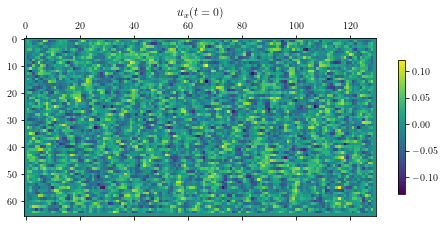

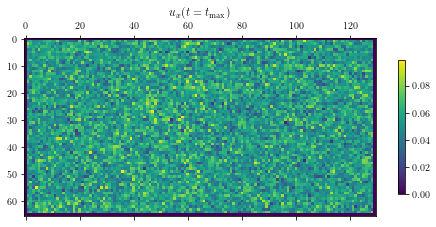

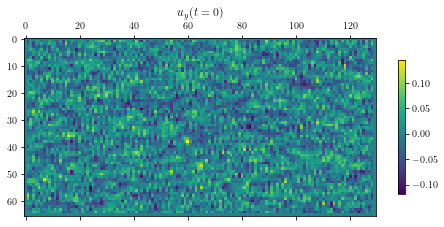

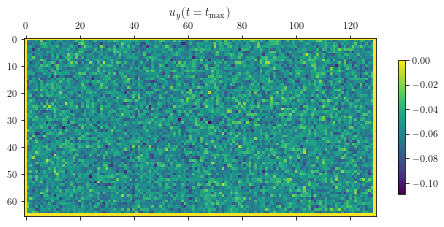

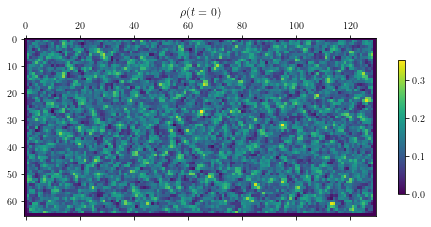

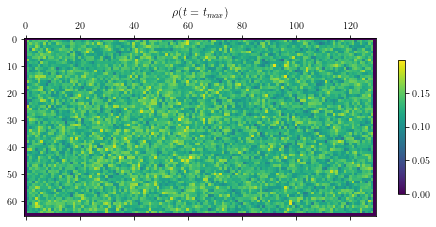

'\nTime series\n'

In [120]:

ux_hist_t0 = plt.matshow(ux_history[1,:,:])
plt.colorbar(ux_hist_t0, shrink=0.6)
plt.title("$u_x(t=0)$")
plt.show()

ux_hist_tmax = plt.matshow(ux_history[-1,:,:])
plt.colorbar(ux_hist_tmax, shrink=0.6)
plt.title("$u_x(t=t_\mathrm{max})$")
plt.show()

uy_hist_t0 = plt.matshow(uy_history[1,:,:])
plt.colorbar(uy_hist_t0, shrink=0.6)
plt.title("$u_y(t=0)$")
plt.show()

uy_hist_tmax = plt.matshow(uy_history[-1,:,:])
plt.colorbar(uy_hist_tmax, shrink=0.6)
plt.title("$u_y(t=t_\mathrm{max})$")
plt.show()

rho_hist_t0 = plt.matshow(rho_history[1,:,:])
plt.colorbar(rho_hist_t0, shrink=0.6)
plt.title(r"$\rho(t=0)$")
plt.show()

rho_hist_tmax = plt.matshow(rho_history[-1,:,:])
plt.colorbar(rho_hist_tmax, shrink=0.6)
plt.title(r"$\rho(t=t_{max})$")
plt.show()

"""
Time series
"""
# numerical_contourplot = []
# for i in range(time_steps):
#     numerical_contourplot.append( plt.matshow(ux_history[i,:,:],vmin=-1,vmax=1) )
#     plt.colorbar(numerical_contourplot[i], shrink=0.6)
#     plt.title("time step ="+str(i))
# plt.xlabel("x")
# plt.ylabel("y")
# plt.xlim(1,Nx)
# plt.ylim(1,Ny)

### Density profile

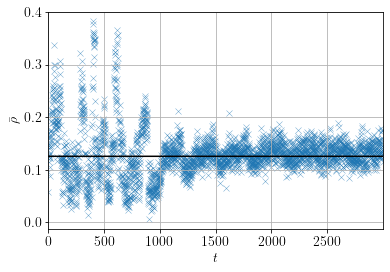

/var/folders/qb/kz2h3qwj4qqg8yl1shdvlnkr0000gn/T/ipykernel_57732/1326840404.py:27: UserWarning: Attempted to set non-positive left xlim on a log-scaled axis.
Invalid limit will be ignored.
  plt.xlim([min(time_series), max(time_series)])


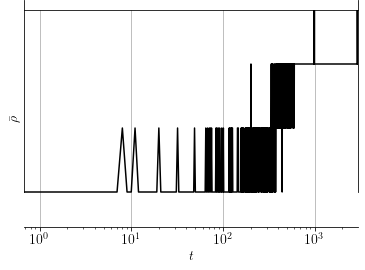

In [121]:
"""
Calculate and plot mean density
"""
plt.rcParams.update({
    "font.size": 14,
    "text.usetex": True})

rho_mean_history = np.mean(rho_history, axis=(1,2))
time_series = range(0,time_steps)
plt.plot(time_series,rho_mean_history, color='black', label="Mean density")
plt.scatter(time_series, rho_history[:,int(Nx/2),int(Ny/2)], alpha=0.65, marker='x', linewidths=0.5, label="Density at center")
plt.ylabel(r'$\bar{\rho}$')
plt.xlabel(r'$t$')
plt.grid()
plt.xlim([min(time_series), max(time_series)])
plt.show()

"""
Calculate and plot mean density
"""
rho_mean_history = np.mean(rho_history, axis=(1,2))
time_series = range(0,time_steps)
plt.loglog(time_series,rho_mean_history, color='black')
plt.ylabel(r'$\bar{\rho}$')
plt.xlabel(r'$t$')
plt.grid()
plt.xlim([min(time_series), max(time_series)])
plt.show()

## Order parameter

In [122]:
initial_order_parameter_ux = np.average(ux_history[1,:,:], weights=rho_history[1,:,:])
initial_order_parameter_uy = np.average(uy_history[1,:,:], weights=rho_history[1,:,:])


order_parameter_ux = np.average(ux_history[-1,:,:], weights=rho_history[-1,:,:])
order_parameter_uy = np.average(uy_history[-1,:,:], weights=rho_history[-1,:,:])

print(initial_order_parameter_ux)
print(initial_order_parameter_uy)
print(order_parameter_ux)
print(order_parameter_uy)

0.00010028701446822023
-0.00029870924888591657
0.05531598869812748
-0.0551579604737995


### Saving Animations and Input Params

In [123]:
if not write_output_data:
    import sys
    sys.exit("Goodbye.")

import os
from datetime import date
from datetime import datetime
import scipy.io

directory = os.path.join("output/", VERSION + "_" + str(datetime.now()))
os.mkdir(directory)
  
"""
Write down input parameters.
"""
with open(directory+"/input.txt","w") as file:
    file.write("time_steps: " + str(time_steps) + "\n")
    file.write("sigma: " + str(sigma) + "\n")
    file.write("rho_mean_init: " + str(rho_mean_init) + "\n")
    file.write("A: " + str(A) + "\n")
    file.write("B: " + str(B) + "\n")
    file.write("------------------------- \n")
    file.write("initial_order_ux: " + str(initial_order_parameter_ux) + "\n")
    file.write("initial_order_uy: " + str(initial_order_parameter_uy) + "\n")
    file.write("final_order_ux: " + str(order_parameter_ux) + "\n")
    file.write("final_order_uy: " + str(order_parameter_uy) + "\n")

scipy.io.savemat(directory+'/output.mat', {'rho_history': rho_history, 'ux_history': ux_history, 'uy_history': uy_history})


In [124]:
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation

plt.rcParams.update({
    "font.size": 18,
    "text.usetex": True})

fig, ax = plt.subplots(figsize=(15,15))

image = ax.matshow(rho_history[0,:,:])
ax.set_title(r"$\sigma="+str(np.round(sigma,4))+"$ $A="+str(A)+"$ $B="+str(B)+"$ $\\bar{\\rho}="+str(rho_mean_init)+"$")

plt.colorbar(image, orientation='horizontal')

def animate(i):
    return image.set_data(rho_history[i,:,:])

anim = FuncAnimation(fig, animate, interval=50, frames=time_steps)
anim.save(directory+"/animation_rho.mp4")


<IPython.core.display.Javascript object>

In [125]:

fig, ax = plt.subplots(figsize=(15,15))

image = ax.matshow(ux_history[0,:,:])
ax.set_title(r"$\sigma="+str(np.round(sigma,4))+"$ $A="+str(A)+"$ $B="+str(B)+"$ $\\bar{\\rho}="+str(rho_mean_init)+"$")
plt.colorbar(image, orientation='horizontal')

def animate(i):
    return image.set_data(ux_history[i,:,:])

anim = FuncAnimation(fig, animate, interval=50, frames=time_steps)
anim.save(directory+"/animation_ux.mp4")


<IPython.core.display.Javascript object>

In [126]:

fig, ax = plt.subplots(figsize=(15,15))

image = ax.matshow(uy_history[0,:,:])
ax.set_title(r"$\sigma="+str(np.round(sigma,4))+"$ $A="+str(A)+"$ $B="+str(B)+"$ $\\bar{\\rho}="+str(rho_mean_init)+"$")
plt.colorbar(image, orientation='horizontal')

def animate(i):
    return image.set_data(uy_history[i,:,:])

anim = FuncAnimation(fig, animate, interval=50, frames=time_steps)
anim.save(directory+"/animation_uy.mp4")


<IPython.core.display.Javascript object>

In [127]:
speed_history = np.sqrt(np.square(ux_history)+np.square(uy_history))

fig, ax = plt.subplots(figsize=(15,15))

image = ax.matshow(speed_history[0,:,:])
ax.set_title(r"$\sigma="+str(np.round(sigma,4))+"$ $A="+str(A)+"$ $B="+str(B)+"$ $\\bar{\\rho}="+str(rho_mean_init)+"$")
plt.colorbar(image, orientation='horizontal')

def animate(i):
    return image.set_data(speed_history[i,:,:])

anim = FuncAnimation(fig, animate, interval=50, frames=time_steps)
anim.save(directory+"/animation_speed.mp4")


<IPython.core.display.Javascript object>